In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import json
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

In [3]:
pd.__version__

u'0.17.1'

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

driver = webdriver.Chrome(executable_path="./chromedriver")
url = "http://stats.nba.com/league/player/#!/gamelogs/?sort=PLAYER_NAME&dir=-1&Season=2014-15&SeasonType=Regular%20Season"
driver.get(url)
print driver.title

NBA.com/Stats


In [434]:
%connect_info

{
  "stdin_port": 51928, 
  "ip": "127.0.0.1", 
  "control_port": 51929, 
  "hb_port": 51930, 
  "signature_scheme": "hmac-sha256", 
  "key": "50c44b7d-1656-4bb7-9a9c-65d9f4325096", 
  "shell_port": 51926, 
  "transport": "tcp", 
  "iopub_port": 51927
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-7d97c242-1afa-4c9e-948c-b31fd1a2f89f.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [7]:
right_arrow = driver.find_element_by_css_selector("div.page-nav.right")

In [9]:
right_arrow.click()

In [94]:
def dump_season_gamelogs(y1,y2):
    base_url_head = 'http://stats.nba.com/stats/leaguegamelog?Counter=1000&Direction=DESC&LeagueID=00&PlayerOrTeam=P&Season='
    base_url_years = [str(y-1) + '-' + str(y)[2:] for y in range(y2,y1,-1)]
    base_url_tail = '&SeasonType=Regular+Season&Sorter=PTS'
    base_url_years
    gamelog_urls = [base_url_head + years + base_url_tail for years in base_url_years]

    for i in range(len(gamelog_urls)):
        gamelog_resp = requests.get(gamelog_urls[i])
        gamelog_resp.raise_for_status()
        gamelog_json = gamelog_resp.json()['resultSets'][0]
        gamelog_headers = gamelog_json['headers']
        
        gamelog_rows = gamelog_json['rowSet']
        df = pd.DataFrame(gamelog_rows, columns = gamelog_headers)
#         fd = open("./gamelogs/" + base_url_years[i] + ".json","w")
#         json.dump(gamelog_json, fd)
#         fd.close()
        df.to_csv("./gamelogs/" + base_url_years[i] + ".csv", index = False)
        time.sleep(1)

In [ ]:
'http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision='

In [98]:
dump_season_gamelogs(1980,2016)

In [109]:
df = pd.read_csv("./gamelogs/2014-15.csv")

In [106]:
df.shape

(19387, 30)

In [164]:
name_2_id = {}

In [140]:
name_2_id["Kobe Bryant"]

977

In [163]:
years = [str(y-1) + '-' + str(y)[2:] for y in range(2016,1980,-1)]

In [165]:
def loadlog(year, name_2_id):
    df = pd.read_csv("./gamelogs/" + year + ".csv")
    for k, v in df.groupby("PLAYER_NAME")["PLAYER_ID"]:
        name_2_id.update({k:v.iloc[0]})
    return df

fulldf = reduce(lambda x,y: pd.concat([loadlog(y,name_2_id),x]),years, pd.DataFrame())

In [169]:
name_2_id["Nick Young"]

201156

In [26]:
def scoring_func(log_row):
    stats = ["PTS","FG3M","REB","AST","STL","BLK","TOV"]
    double_stats = ["PTS","REB","AST","BLK","STL"]
    doubles = sum([1 if (log_row[d] - 10) >= 0 else 0 for d in double_stats])
    double_points = 0
    if doubles == 2:
        double_points = 1.5
    if doubles > 2:
        double_points = 3.
    points = [1,.5,1.25,1.5,2,2,-.5]
    total = sum([p * log_row[s] for p,s in zip(points,stats)])# + double_points
    return total

Point = +1 PT

Made 3pt. shot = +0.5 PTs

Rebound = +1.25 PTs

Assist = +1.5 PTs

Steal = +2 PTs

Block = +2 PTs

Turnover = -0.5 PTs

Double-Double = +1.5PTs (MAX 1 PER PLAYER: Points, Rebounds, Assists, Blocks, Steals)

Triple-Double = +3PTs (MAX 1 PER PLAYER: Points, Rebounds, Assists, Blocks, Steals)

In [61]:
post86df = pd.read_csv('./gamelogs/master_post86df.csv')

In [34]:
post86df.index

NameError: name 'post86df' is not defined

In [46]:
from datetime import datetime
post86df["GAME_DATE"] = pd.to_datetime(post86df["GAME_DATE"])
post86df = post86df.drop('VIDEO_AVAILABLE',1)
post86df = post86df.sort("GAME_DATE", ascending = False)

In [8]:
def season_subset(df, year_season_start, year_season_end = None):
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    if year_season_end is None:
        year_season_end = year_season_start + 1
    df_gt = df[df.GAME_DATE > datetime(year_season_start,9,1)]
    df_lt = df_gt[df_gt.GAME_DATE < datetime(year_season_end,9,1)]
    return df_lt.sort("GAME_DATE") if not df_lt.empty else None

In [409]:
name2id = pd.read_csv("./gamelogs/master_name2id.csv")
playerIDs = name2id["PLAYER_ID"]
def get_player_bio(df2,playerID):
    url_head = "http://stats.nba.com/stats/commonplayerinfo?LeagueID=00&PlayerID=" 
    url_tail = "&SeasonType=Regular+Season"

    resp = requests.get(url_head + str(playerID) + url_tail)
    resp.raise_for_status()
    json_data = resp.json()['resultSets'][0]
    headers = json_data['headers']
    rows = json_data['rowSet']
    df1 = pd.DataFrame(rows, columns = headers)
    time.sleep(1)
    return pd.concat([df1,df2])
    

#player_bios_df = reduce(lambda x,y: get_player_bio(x,y), playerIDs,pd.DataFrame())

In [418]:
player_bios_df = player_bios_df.rename(columns = {'PERSON_ID': 'PLAYER_ID', 'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})
player_bios_df["BIRTHDATE"] = pd.to_datetime(player_bios_df["BIRTHDATE"])
player_bios_df['AGE'] = player_bios_df["BIRTHDATE"].map(lambda x: round((pd.to_datetime('today') - x).days / 365.,2))
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].map(lambda x: float(x) if len(x) > 0 else float('nan'))
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].map(lambda x: (12.*float(x[0]) + float(x[2:])) if len(x) > 0 else float('nan'))

In [222]:
y1 = 1985
test_date = df85_15["GAME_DATE"] > datetime(y1,9,1)
while not all((df85_15.WEIGHT[test_date] > 0) & (df85_15.HEIGHT[test_date] > 0)):
    y1 += 1
    test_date = df85_15["GAME_DATE"] > datetime(y1,9,1)
  

In [433]:
%connect_info

{
  "stdin_port": 51928, 
  "ip": "127.0.0.1", 
  "control_port": 51929, 
  "hb_port": 51930, 
  "signature_scheme": "hmac-sha256", 
  "key": "50c44b7d-1656-4bb7-9a9c-65d9f4325096", 
  "shell_port": 51926, 
  "transport": "tcp", 
  "iopub_port": 51927
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-7d97c242-1afa-4c9e-948c-b31fd1a2f89f.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [1057]:
by_pn = df85_15.groupby("PLAYER_NAME")
df85_15["FANTASY_ZSCORE"] = by_pn["FANTASY_PTS"].apply(lambda x: ((x - x.mean())/x.std()))
df85_15["i_ZSCORE_OVER"] = df85_15["FANTASY_ZSCORE"].map(lambda x: 1 if x > 1 else 0)
df85_15["SEASON_MIN"] = by_pn['MIN'].apply(lambda x: x.map(lambda y: x.sum()))
df85_15["GAMES_PLAYED"] = by_pn["PLAYER_NAME"].apply(lambda x: x.map(lambda y: len(x)))
for x in ['FG_PCT', 'FG3_PCT', 'FT_PCT']:
    df85_15[x] = df85_15[x].map(lambda y: 0 if np.isnan(y) else y)
df85_15["WL"] = [1 if v == "W" else 0 for v in df85_15.copy()["WL"]]


In [282]:
five_days_df = season_subset(df85_15,2014).groupby("PLAYER_NAME").apply(lambda x: pd.DataFrame(map(lambda y: calc_ngame_avg(x.sort_values("GAME_DATE"),["AST","FANTASY_PTS"],y,5),x.GAME_DATE)))

In [16]:
kde_cols = ['WL','MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT',
'OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS','DAY_NUM', 'AGE', 'WEIGHT', 'HEIGHT','AWAY', 'elo_i',
'win_equiv','opp_elo_i','forecast']

In [128]:
#pd.merge(pd.DataFrame(abrooks_avg[0]),pd.DataFrame(abrooks_avg[1]),left_index = True, right_index = True)

abrooks_dfs = map(lambda x: pd.DataFrame(x),abrooks_avg)
merged = reduce(lambda x,y: pd.merge(x,y,left_index = True, right_index = True),abrooks_dfs,pd.DataFrame(index=abrooks_dfs[0].index))

In [461]:
test = season_subset(df85_15,2014)
test_no_nan = test[~pd.isnull(test.POSITION)]

In [492]:
?pd.DataFrame.groupby

In [613]:
from datetime import datetime, timedelta
dfs14["GAME_DATE"] = pd.to_datetime(dfs14["GAME_DATE"])
game_dates = dfs14.sort("GAME_DATE", ascending = False)
day_date_tuples = list(enumerate(pd.date_range(game_dates["GAME_DATE"].min(), game_dates["GAME_DATE"].max())))
date_day_dict = {}
for k,v in day_date_tuples:
    date_day_dict.update({v:k})

by_date = dfs14.groupby("GAME_DATE")
dfs14["DAY_NUM"] = by_date["GAME_DATE"].apply(lambda x: x.map(lambda y: date_day_dict[y]))

In [614]:
by_player = dfs14.groupby("PLAYER_NAME")
dfs14["AGE"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: float(player_bios_df[player_bios_df.PLAYER_NAME == y]['AGE'])))
dfs14["WEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: float(player_bios_df[player_bios_df.PLAYER_NAME == y]['WEIGHT'])))
dfs14["HEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: float(player_bios_df[player_bios_df.PLAYER_NAME == y]['HEIGHT'])))

In [ ]:
#your code here
dfs14_elo_gb=dfs14_elo.groupby("i_FANTASY_OVER_STD")
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(20, 36), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), kde_cols):
    for k, v in dfs14_elo_gb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)
        if v.name == "AWAY":
            ax.set_xlim(-.1,1.1)

In [241]:
pd.to_datetime("2015-4-3")

Timestamp('2015-04-03 00:00:00')

In [33]:
pd.DataFrame({'a':[]}).nlargest(4,'a')

,a


In [615]:
opp_away = dfs14.MATCHUP.map(lambda x: (x[-3:],0) if "@" in x else (x[-3:],1))
dfs14["OPP"] = opp_away.map(lambda x: x[0])
dfs14["IS_HOME"] = opp_away.map(lambda x: x[1])

### Historical NBA Elo

This directory contains the data behind the [Complete History Of The NBA](http://fivethirtyeight.com/interactives/the-complete-history-of-every-nba-team-by-elo) interactive. Data updated periodically. Game information is from [Basketball-Reference.com](http://www.basketball-reference.com/).

In the data file `nbaallelo.csv` are the following variables:

Header | Definition
---|---------
`gameorder` | Play order of game in NBA history
`game_id` | Unique ID for each game
`lg_id` | Which league the game was played in
`_iscopy` | Each row of data is tied to a single team for a single game, so _iscopy flags if this game_id has already occured for the opposing team in the same matchup
`year_id` | Season id, named based on year in which the season ended
`date_game` | Game date
`is_playoffs` | Flag for playoff games
`team_id` | Three letter code for team name, from Basketball Reference
`fran_id` | Franchise id. Multiple team_ids can fall under the same fran_id due to name changes or moves. Interactive is grouped by fran_id.
`pts` | Points scored by team
`elo_i` | Team elo entering the game
`elo_n` | Team elo following the game
`win_equiv` | Equivalent number of wins in a 82-game season for a team of elo_n quality
`opp_id` | Team id of opponent
`opp_fran` | Franchise id of opponent
`opp_pts` | Points scored by opponent
`opp_elo_i` | Opponent elo entering the game
`opp_elo_n` | Opponent elo following the game
`game_location` | Home (H), away (A), or neutral (N)
`game_result` | Win or loss for team in the team_id column
`forecast` | Elo-based chances of winning for the team in the team_id column, based on elo ratings and game location
`notes` | Additional information

In [981]:
elo_df = pd.read_csv("./gamelogs/all_elo.csv")

elo_df["date_game"] = pd.to_datetime(elo_df["date_game"])
elo_df["game_location"] = elo_df["game_location"].map(lambda x: 0 if x == "H" else 1)

In [794]:
df_test = season_subset(df85_15,2014)
df_test = df_test[~pd.isnull(df_test.POSITION)][df_test.HEIGHT > 0][df_test.WEIGHT > 0]

In [795]:
df_test = df_test[(df_test.PLAYER_NAME == "Andre Iguodala")]

In [796]:
to_roll_cols = [u'ELO', u'OPP_ELO', u'MIN', 'REB', u'AST', u'STL', u'BLK', u'TOV', u'PTS']

In [32]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(kobe_dftest.shape[0]), train_size=0.7)

mask=np.ones(kobe_dftest.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

mask.shape,mask.sum()
Xmatrix=df_test
Xmatrix_train=rolling_cols(Xmatrix[mask],to_roll_cols,3,'mean')
Xmatrix_test=rolling_cols(Xmatrix[~mask],to_roll_cols,3,'mean')
Xmatrix_train = Xmatrix_train.set_index('GAME_DATE')
Xmatrix_train[Xmatrix_train.columns.tolist()[:-1]] = Xmatrix_train[Xmatrix_train.columns.tolist()[:-1]].shift(1)
Xmatrix_train = Xmatrix_train.dropna()
Xmatrix_train;
Xmatrix_test = Xmatrix_test.set_index('GAME_DATE')
Xmatrix_test[Xmatrix_test.columns.tolist()[:-1]] = Xmatrix_test[Xmatrix_test.columns.tolist()[:-1]].shift(1)
Xmatrix_test = Xmatrix_test.dropna()
Xmatrix_test;

x_train, x_test = Xmatrix_train.copy(), Xmatrix_test.copy()
dftest = df_test.copy()

((1213,), 849)

In [569]:
dftest["GAME_DATE"] = dftest["GAME_DATE"].astype(np.int64)

In [681]:
df_test.columns

Index([u'PLAYER_NAME', u'SEASON_ID', u'R_AGE', u'R_WEIGHT', u'R_HEIGHT', u'R_ELO', u'R_EXP_WINS', u'R_OPP_ELO', u'R_FORECAST', u'R_MIN', u'R_FGM', u'R_FGA', u'R_FG_PCT', u'R_FG3M', u'R_FG3A', u'R_FG3_PCT', u'R_FTM', u'R_FTA', u'R_FT_PCT', u'R_OREB', u'R_DREB', u'R_REB', u'R_AST', u'R_STL', u'R_BLK', u'R_TOV', u'R_PF', u'R_PTS', u'R_PLUS_MINUS', u'FANTASY_PTS'], dtype='object')

In [756]:
Xmatrix_train.columns

Index([u'PLAYER_NAME', u'SEASON_ID', u'R_AGE', u'R_WEIGHT', u'R_HEIGHT', u'R_ELO', u'R_EXP_WINS', u'R_OPP_ELO', u'R_FORECAST', u'R_MIN', u'R_FGM', u'R_FGA', u'R_FG_PCT', u'R_FG3M', u'R_FG3A', u'R_FG3_PCT', u'R_FTM', u'R_FTA', u'R_FT_PCT', u'R_OREB', u'R_DREB', u'R_AST', u'R_STL', u'R_BLK', u'R_TOV', u'R_PTS', u'FANTASY_PTS'], dtype='object')

In [802]:
STANDARDIZABLE = ['FANTASY_PTS'] + map(lambda x: 'R_' + x,to_roll_cols)

In [803]:
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=Xmatrix_train[col].values
    valstest=Xmatrix_test[col].values
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    x_train[col] = outtrain
    x_test[col] = outtest

FANTASY_PTS
R_ELO
R_OPP_ELO
R_MIN
R_REB
R_AST
R_STL
R_BLK
R_TOV
R_PTS


In [804]:
lcols=list(STANDARDIZABLE)

In [ ]:
df14gb=df14.groupby("i_FANTASY_OVER_STD")
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(20, 36), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), lcols):
    for k, v in df14gb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

In [805]:
from sklearn import linear_model

clfridge = linear_model.Ridge()
alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Yresp_train = x_train['FANTASY_PTS'].values
Yresp_test = x_test['FANTASY_PTS'].values

In [806]:
Yresp_train;

In [807]:
#your code here
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfridge, param_grid={'alpha':alphas}, cv=5)
gs.fit(x_train[lcols], Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'alpha': 0.001} 0.999999998223 [mean: 1.00000, std: 0.00000, params: {'alpha': 0.001}, mean: 1.00000, std: 0.00000, params: {'alpha': 0.01}, mean: 0.99998, std: 0.00001, params: {'alpha': 0.1}, mean: 0.99845, std: 0.00047, params: {'alpha': 1.0}, mean: 0.92484, std: 0.01664, params: {'alpha': 10.0}, mean: 0.34670, std: 0.09334, params: {'alpha': 100.0}]


In [808]:
#calculate the accuracy here
#your code here
best = gs.best_estimator_
best.fit(x_train[lcols], Yresp_train)
best.score(x_test[lcols], Yresp_test)

0.99999999948343488

In [812]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
#your code here
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [816]:
def make_mask(df):
    from sklearn.cross_validation import train_test_split
    itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)

    mask=np.ones(df.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [813]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, gen_mask = False, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    
    if gen_mask:  
        print "using mask"
        mask = make_mask(indf)
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [817]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(Linear, {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df85_15[df85_15.PLAYER_NAME == "Kobe Bryant"],to_roll_cols, 'FANTASY_PTS',1, gen_mask = True)

using mask
BEST {'alpha': 0.001} 1.0 [mean: 1.00000, std: 0.00000, params: {'alpha': 0.001}, mean: 1.00000, std: 0.00000, params: {'alpha': 0.01}, mean: 1.00000, std: 0.00000, params: {'alpha': 0.1}, mean: 1.00000, std: 0.00000, params: {'alpha': 1.0}, mean: 1.00000, std: 0.00000, params: {'alpha': 10.0}, mean: 1.00000, std: 0.00000, params: {'alpha': 100.0}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[364]]
########################################################
CPU times: user 53.8 ms, sys: 38.3 ms, total: 92 ms
Wall time: 170 ms


In [945]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [585]:
print "whole data set", dftest['FANTASY_PTS'].mean()#Decently symmetric
print "training set", dftest['FANTASY_PTS'][mask].mean(), "test set", dftest['FANTASY_PTS'][~mask].mean()

 whole data set 3.73124354622e-17
training set 1.159534961e-16 test set -1.51950247818e-17


In [ ]:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df85_15[df85_15.PLAYER_NAME == "Kobe Bryant"],lcols, u'FANTASY_PTS',1, mask=mask)

In [1]:
%connect_info

{
  "stdin_port": 62468, 
  "ip": "127.0.0.1", 
  "control_port": 62469, 
  "hb_port": 62470, 
  "signature_scheme": "hmac-sha256", 
  "key": "f42fff0f-7a67-4ab0-be05-0508d18adf7c", 
  "shell_port": 62466, 
  "transport": "tcp", 
  "iopub_port": 62467
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-01760c43-76cf-43d2-8c36-b1cbf4a8c27a.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [64]:
kobe_df = (df85_15[df85_15.PLAYER_NAME == "Kobe Bryant"].groupby(["PLAYER_NAME","SEASON_ID"])
                            .apply(lambda x: pd.DataFrame(map(lambda y: calc_ngame_avg(x.sort_values("GAME_DATE"),["AST","REB","PTS","OPP_ELO"],y,5),x.GAME_DATE)))).reset_index().drop('level_2',axis = 1)
kobe_df = pd.merge(kobe_df,df85_15[df85_15.PLAYER_NAME == "Kobe Bryant"][["GAME_DATE","FANTASY_PTS"]])
kobe_dftest = kobe_df.set_index('GAME_DATE')

In [97]:
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfridge, param_grid={'alpha':alphas}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

#calculate the accuracy here
best = gs.best_estimator_
best.fit(Xmatrix_train, Yresp_train)
best.score(Xmatrix_test, Yresp_test)

BEST {'alpha': 0.001} -0.147590442654 [mean: -0.14759, std: 0.11567, params: {'alpha': 0.001}, mean: -0.14759, std: 0.11568, params: {'alpha': 0.01}, mean: -0.14762, std: 0.11578, params: {'alpha': 0.1}, mean: -0.14787, std: 0.11677, params: {'alpha': 1.0}, mean: -0.15037, std: 0.12641, params: {'alpha': 10.0}, mean: -0.17301, std: 0.20001, params: {'alpha': 100.0}]


0.38703046266522023

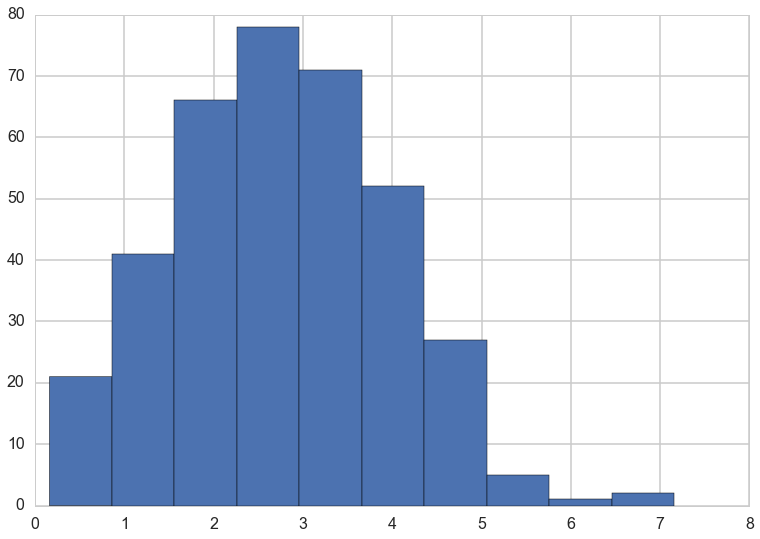

In [102]:
from sklearn.metrics import mean_squared_error
scalar = StandardScaler()
scalar.fit(dftouse['FANTASY_PTS'])
dftouse[~mask]['FANTASY_PTS']
post = pd.DataFrame({'P_FANTASY_PTS':scaler.inverse_transform(best.predict(Xmatrix_test))},index = dftouse[~mask].index) 
pre = df[~mask]
result = pd.merge(post,pre, left_index = True, right_index = True)
np.sqrt((result['FANTASY_PTS'] - result['P_FANTASY_PTS']).map(lambda x: abs(x))).hist()

In [88]:
?mean_squared_error

In [106]:
dftouse[~mask]['FANTASY_PTS']

GAME_DATE
1996-11-03   -2.626496
1996-11-20   -1.712188
1996-11-27   -2.169342
1996-12-01   -2.626496
1996-12-04   -1.847641
1996-12-08   -1.068786
1996-12-21   -2.321727
1996-12-29   -2.626496
1997-01-05   -0.899470
1997-01-14   -2.541838
1997-01-18   -0.611632
1997-01-24   -0.679359
1997-01-26   -2.084684
1997-01-29   -0.645495
1997-02-04   -1.949231
1997-02-05   -2.050821
1997-02-19   -1.661393
1997-02-21   -2.660360
1997-03-02   -1.983094
1997-03-09   -1.187308
1997-03-16   -1.576735
1997-03-17   -1.864573
1997-03-26   -0.730153
1997-03-27   -0.035956
1997-04-02   -1.746051
1997-04-09   -1.492077
1997-04-13   -1.407419
1997-11-07   -2.220137
1997-11-16   -1.915368
1997-11-23    0.150292
                ...   
2012-12-09   -0.002093
2012-12-11    0.861420
2012-12-13    1.013805
2012-12-16    0.471993
2012-12-25    0.150292
2012-12-26    1.216984
2013-01-04    0.742899
2013-01-08   -0.019025
2013-01-11    0.031770
2013-01-13   -0.510042
2013-02-08   -0.019025
2013-02-14   -0.120615
2

In [131]:
%connect_info

{
  "stdin_port": 62468, 
  "ip": "127.0.0.1", 
  "control_port": 62469, 
  "hb_port": 62470, 
  "signature_scheme": "hmac-sha256", 
  "key": "f42fff0f-7a67-4ab0-be05-0508d18adf7c", 
  "shell_port": 62466, 
  "transport": "tcp", 
  "iopub_port": 62467
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-01760c43-76cf-43d2-8c36-b1cbf4a8c27a.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


,PLAYER_NAME,SEASON_ID,5D_AST,5D_BLK,5D_OPP_ELO,5D_PTS,5D_REB,5D_STL,5D_TOV,FANTASY_PTS
GAME_DATE,,,,,,,,,,
2006-11-03,Kobe Bryant,22006,0,0,0.000,0,0,0,0,36
2006-11-05,Kobe Bryant,22006,6,0,1473.391,23,4,1,6,34


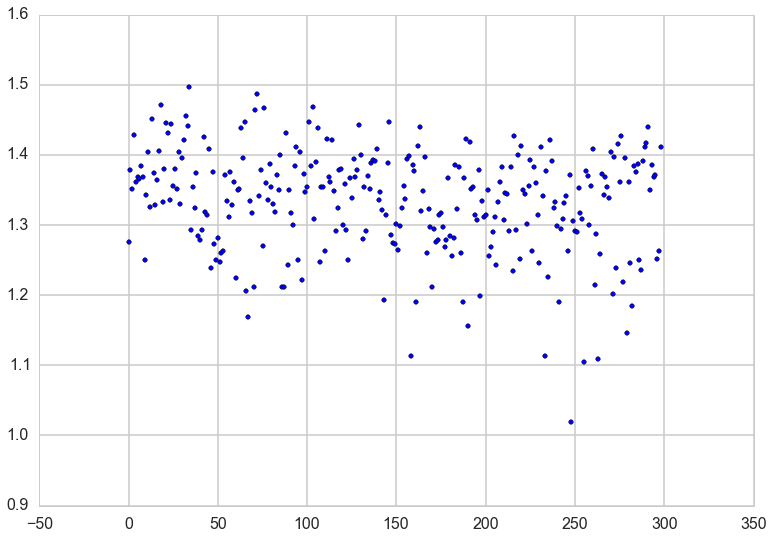

In [249]:
plt.scatter(np.arange(df[mask].shape[0]),np.log(df[mask]['FANTASY_PTS']))

In [250]:
best.__dict__

{'alpha': 100.0,
 'coef_': array([-0.02543369,  0.10638127,  0.02831278, -0.06809144, -0.02449343]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': -5.0097477987260267e-16,
 'max_iter': None,
 'normalize': False,
 'solver': 'auto',
 'tol': 0.001}

In [253]:
dftouse[~mask].head()

,PLAYER_NAME,SEASON_ID,5D_AST,5D_BLK,5D_OPP_ELO,5D_PTS,5D_REB,5D_STL,5D_TOV,FANTASY_PTS
GAME_DATE,,,,,,,,,,
2011-02-22,Kobe Bryant,22010,-1.290705,0.6,0.157174,-0.659105,1.853522,0.2,2.039070,-0.373936
2011-02-10,Kobe Bryant,22010,1.558588,0.2,0.716665,0.843873,1.538859,0.6,0.486967,-0.373936
2011-02-16,Kobe Bryant,22010,-0.620284,0.4,0.474848,-0.558907,1.066864,0.6,1.780386,-0.584474
2011-02-14,Kobe Bryant,22010,-0.117467,0.4,0.634691,0.042285,1.696191,0.6,0.745651,-1.215717
2011-02-13,Kobe Bryant,22010,0.720560,0.4,0.692737,-0.007815,2.482849,0.4,1.004335,-0.971965


In [270]:
kobe_dftest.tail()

,PLAYER_NAME,SEASON_ID,5D_AST,5D_BLK,5D_OPP_ELO,5D_PTS,5D_REB,5D_STL,5D_TOV,FANTASY_PTS
GAME_DATE,,,,,,,,,,
2015-01-04,Kobe Bryant,22014,6.6,0.4,1507.97146,18.6,7.4,1.2,5.2,42.50
2015-01-07,Kobe Bryant,22014,7.2,0.4,1517.53058,18.4,7.8,1.4,5.0,23.50
2015-01-13,Kobe Bryant,22014,7.0,0.4,1528.54350,17.4,7.8,1.6,5.6,32.00
2015-01-15,Kobe Bryant,22014,7.8,0.4,1534.89052,14.8,8.0,1.4,4.2,52.00
2015-01-21,Kobe Bryant,22014,9.0,0.2,1529.19524,14.0,7.0,1.0,3.0,26.25


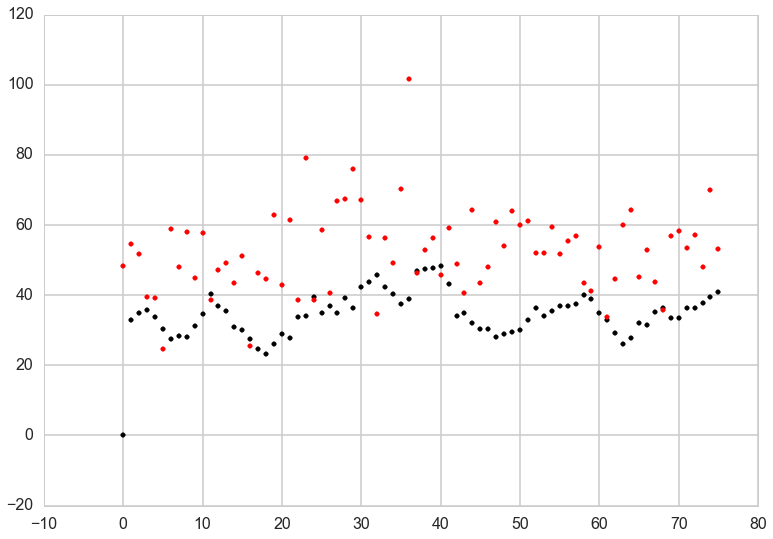

In [271]:
plt.scatter(np.arange(kobe_dftest[kobe_dftest.SEASON_ID == 22005].shape[0]),kobe_dftest[kobe_dftest.SEASON_ID == 22005]['5D_PTS'],color = 'k')
#plt.scatter(np.arange(kobe_dftest[kobe_dftest.SEASON_ID == 22005].shape[0]),np.log(kobe_dftest[kobe_dftest.SEASON_ID == 22005]['5D_AST']),color='g')
#plt.scatter(np.arange(kobe_dftest[kobe_dftest.SEASON_ID == 22005].shape[0]),np.log(kobe_dftest[kobe_dftest.SEASON_ID == 22005]['5D_REB']),color = 'r')
plt.scatter(np.arange(kobe_dftest[kobe_dftest.SEASON_ID == 22005].shape[0]),kobe_dftest[kobe_dftest.SEASON_ID == 22005]['FANTASY_PTS'],color = 'r')











In [275]:
comp = dftouse[~mask][lcols + ['FANTASY_PTS']].copy()
comp['preds'] = best.predict(Xmatrix_test)
comp

,5D_AST,5D_PTS,5D_REB,5D_OPP_ELO,5D_TOV,FANTASY_PTS,preds
GAME_DATE,,,,,,,
2011-02-22,-1.290705,-0.659105,1.853522,0.157174,2.039070,-0.473108,-0.048405
2011-02-10,1.558588,0.843873,1.538859,0.716665,0.486967,-0.473108,0.048086
2011-02-16,-0.620284,-0.558907,1.066864,0.474848,1.780386,-0.660024,-0.091998
2011-02-14,-0.117467,0.042285,1.696191,0.634691,0.745651,-1.167365,-0.004000
2011-02-13,0.720560,-0.007815,2.482849,0.692737,1.004335,-0.980450,-0.012281
2011-02-11,2.229010,-0.057914,1.853522,0.719754,0.745651,0.835299,-0.063455
2011-02-07,1.726193,1.795760,1.066864,0.479045,-0.030401,-0.259491,0.166649
2011-01-21,1.223377,0.593377,0.594869,-0.075612,0.745651,-0.286193,0.050074
2011-02-03,1.390982,1.344866,-0.663785,0.286375,-0.030401,0.060936,0.083768


In [276]:
best.__dict__

{'alpha': 100.0,
 'coef_': array([-0.01989997,  0.11300402,  0.03045706, -0.07324092, -0.02184816]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': 2.1856182265770041e-16,
 'max_iter': None,
 'normalize': False,
 'solver': 'auto',
 'tol': 0.001}

In [291]:
reg_vals = reduce(lambda x, y: y + x,[k * v for k,v in zip(np.array(best.coef_),[dftouse[~mask][l].values for l in lcols])],0) + best.intercept_

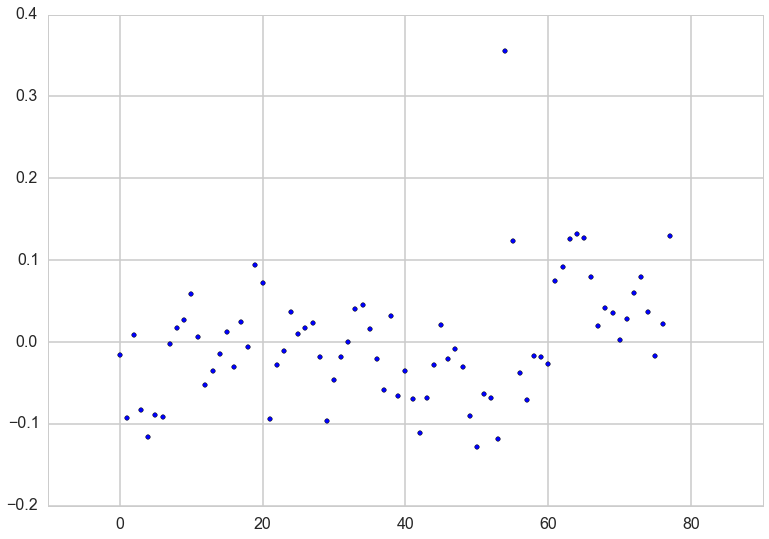

In [299]:
plt.scatter(np.arange(len(best.predict(Xmatrix_test))),best.predict(Xmatrix_test))

In [307]:
(Yresp_test - best.predict(Xmatrix_test)).mean()

-2.5051186196670199e-16

In [308]:
?best.score

In [316]:
?SVR

In [1]:
%connect_info

{
  "stdin_port": 50314, 
  "ip": "127.0.0.1", 
  "control_port": 50315, 
  "hb_port": 50316, 
  "signature_scheme": "hmac-sha256", 
  "key": "85e38763-5dba-45b8-9605-983f1f39c4c1", 
  "shell_port": 50312, 
  "transport": "tcp", 
  "iopub_port": 50313
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-47c8c1a7-6590-48e2-a0ab-0d1400b895ff.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [16]:
kobe_dftest.head()

,PLAYER_NAME,SEASON_ID,5D_AST,5D_BLK,5D_OPP_ELO,5D_PTS,5D_REB,5D_STL,5D_TOV,FANTASY_PTS
GAME_DATE,,,,,,,,,,
1996-11-03,Kobe Bryant,21996,0,0.000000,0.00000,0.0,0.000000,0,0.000000,2.75
1996-11-05,Kobe Bryant,21996,0,1.000000,1396.93350,0.0,1.000000,0,1.000000,0.50
1996-11-06,Kobe Bryant,21996,0,0.500000,1482.24355,0.5,0.500000,0,1.000000,4.00
1996-11-08,Kobe Bryant,21996,0,0.333333,1480.14740,2.0,0.333333,0,1.666667,16.75
1996-11-10,Kobe Bryant,21996,0,0.500000,1440.27030,4.0,1.000000,0,1.250000,7.25


In [28]:
fantasy_resp = kobe_dftest.groupby('SEASON_ID').apply(lambda x: x['FANTASY_PTS'].map(lambda y: 1 if y > x.FANTASY_PTS.mean() else 0)).reset_index().rename(columns={'FANTASY_PTS':'FANTASY_RESP'})

kobe_dftest2 = pd.merge(kobe_dftest,fantasy_resp)

In [29]:
kobe_dftest = kobe_dftest2

In [26]:
?SVM

Object `SVM` not found.


In [29]:
?SVC

In [103]:
seasoniddates = post85df.groupby("SEASON_ID").filter(lambda x: x.name > 21995).groupby('SEASON_ID').apply(lambda x: {int(x.name):list(set(x.GAME_DATE))}).values.tolist()

In [104]:
season_dict = {}
for d in seasoniddates:
    season_dict.update(d)

In [2]:
post85df = pd.read_csv('./gamelogs/master_post86df.csv')

In [105]:
season_dict

{21996: ['1996-11-09',
  '1996-11-08',
  '1996-11-05',
  '1996-11-04',
  '1996-11-07',
  '1996-11-06',
  '1996-11-01',
  '1996-11-03',
  '1996-11-02',
  '1997-03-25',
  '1997-01-08',
  '1997-03-27',
  '1997-03-26',
  '1997-03-21',
  '1997-03-20',
  '1997-03-23',
  '1997-03-22',
  '1997-01-03',
  '1997-01-02',
  '1997-03-29',
  '1997-03-28',
  '1997-01-07',
  '1997-01-06',
  '1996-12-19',
  '1996-12-18',
  '1996-12-17',
  '1996-12-16',
  '1996-12-15',
  '1996-12-14',
  '1996-12-13',
  '1996-12-12',
  '1996-12-11',
  '1996-12-10',
  '1997-02-04',
  '1997-02-05',
  '1997-02-06',
  '1997-02-01',
  '1997-02-02',
  '1997-02-03',
  '1997-03-10',
  '1997-03-11',
  '1997-03-12',
  '1997-03-13',
  '1997-03-14',
  '1997-03-15',
  '1997-03-16',
  '1997-03-17',
  '1997-01-30',
  '1997-01-31',
  '1997-02-19',
  '1997-02-18',
  '1997-02-13',
  '1997-02-12',
  '1997-02-11',
  '1997-02-17',
  '1997-02-16',
  '1997-02-15',
  '1997-02-14',
  '1996-11-27',
  '1996-11-26',
  '1996-11-25',
  '1996-11-24',
 

In [65]:
import datetime
#post85df.head()
by_season = post85df.groupby("SEASON_ID")
#by_season.head()
seasondates = list(set(post85df[post85df.SEASON_ID == 21985]['GAME_DATE']))
#seasondates = list(set(pd.to_datetime(post85df[post85df.SEASON_ID == 21985]['GAME_DATE'], format="%Y-%m-%d")))

'06'

In [78]:
for s,gdates in season_dict.items():
    season_dict[s] = [gdate[5:7]+'%2F'+gdate[8:10]+'%2F'+gdate[:4] for gdate in gdates]

In [110]:
season_dict

{21996: ['1996-11-09',
  '1996-11-08',
  '1996-11-05',
  '1996-11-04',
  '1996-11-07',
  '1996-11-06',
  '1996-11-01',
  '1996-11-03',
  '1996-11-02',
  '1997-03-25',
  '1997-01-08',
  '1997-03-27',
  '1997-03-26',
  '1997-03-21',
  '1997-03-20',
  '1997-03-23',
  '1997-03-22',
  '1997-01-03',
  '1997-01-02',
  '1997-03-29',
  '1997-03-28',
  '1997-01-07',
  '1997-01-06',
  '1996-12-19',
  '1996-12-18',
  '1996-12-17',
  '1996-12-16',
  '1996-12-15',
  '1996-12-14',
  '1996-12-13',
  '1996-12-12',
  '1996-12-11',
  '1996-12-10',
  '1997-02-04',
  '1997-02-05',
  '1997-02-06',
  '1997-02-01',
  '1997-02-02',
  '1997-02-03',
  '1997-03-10',
  '1997-03-11',
  '1997-03-12',
  '1997-03-13',
  '1997-03-14',
  '1997-03-15',
  '1997-03-16',
  '1997-03-17',
  '1997-01-30',
  '1997-01-31',
  '1997-02-19',
  '1997-02-18',
  '1997-02-13',
  '1997-02-12',
  '1997-02-11',
  '1997-02-17',
  '1997-02-16',
  '1997-02-15',
  '1997-02-14',
  '1996-11-27',
  '1996-11-26',
  '1996-11-25',
  '1996-11-24',
 

In [ ]:
'http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=\
11%2F11%2F2014&DateTo=11%2F12%2F2014&\
Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&\
Season=2014-15&\
SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision='

In [ ]:
'http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=\
11%2F04%2F2014&DateTo=11%2F04%2F2014&\
Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&\
Season=2014-15&\
SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision='

In [117]:
def dump_season_gamelogs(sdict):
    store_df = []
    for seasonid, gdatestrings in sdict.items():
        base_url_head = 'http://stats.nba.com/stats/leaguedashteamstats?Conference=&'
        base_url_dates = ['DateFrom='+gdatestring+'&DateTo='+gdatestring+'&' for gdatestring in gdatestrings]
        base_url_middle = 'Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season='
        season = str(seasonid)[1:]
        base_url_year = season + '-' + str(int(season)+1)[-2:]
        base_url_tail = '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision='
        gamelog_urls = [base_url_head + base_url_date + base_url_middle + base_url_year + base_url_tail for base_url_date in base_url_dates]
        print seasonid
        
        for i in range(len(gamelog_urls)):
            gamelog_resp = requests.get(gamelog_urls[i])
            gamelog_resp.raise_for_status()
            gamelog_json = gamelog_resp.json()['resultSets'][0]
            gamelog_headers = gamelog_json['headers']
            gamelog_rows = gamelog_json['rowSet']
            df = pd.DataFrame(gamelog_rows, columns = gamelog_headers)
            df['SEASON_ID'] = [seasonid for k in range(df.shape[0])]
            df['GAME_DATE'] = [gdatestrings[i].replace('%2F','-') for k in range(df.shape[0])]
            store_df.append(df)
            time.sleep(1)           
        pd.concat(store_df).to_csv('./defense_stats/' + str(seasonid) + '.csv', index = False)
        store_df = []
    return store_df

In [ ]:
defensedf = dump_season_gamelogs(season_dict)

21996
21997
21998

In [ ]:
df85_15.groupby('PLAYER_NAME').apply(lambda x: x.map(lambda y: x.iloc[x.index.tolist()[y]] - x.iloc[x.index.tolist()[y+1]],range(x.shape[0])))